# Nearest Earth Objects Classification and Prediction
Aim of the project to classify and predict the nearest earth objects from the NASA.

# DataSet
I have Downloaded this dataset from kaggle website. Here is the link: https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects.

# What are we required to do
We have to classify and predict the nearest earth objects from the NASA.

# Importing the Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv("neo_v2.csv")
df[0:2].T

,0,1
id,2162635,2277475
name,162635 (2000 SS164),277475 (2005 WK4)
est_diameter_min,1.198271,0.2658
est_diameter_max,2.679415,0.594347
relative_velocity,13569.249224,73588.726663
miss_distance,54839744.082846,61438126.523951
orbiting_body,Earth,Earth
sentry_object,False,False
absolute_magnitude,16.73,20.0
hazardous,False,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [6]:
df1=labelencoder(df)

# Target setting

In [7]:
m=len(df1)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

In [9]:
target=['hazardous']
dataY=df1[target]
dataX=df1.drop(target,axis=1)

In [10]:
df_columns = list(dataX.columns)
print(df_columns)

['id', 'name', 'est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object', 'absolute_magnitude']


In [11]:
trainX=dataX.iloc[M[0:(m//4)*3]]
trainY=dataY.iloc[M[0:(m//4)*3]]
testX=dataX.iloc[M[(m//4)*3:]]
testY=dataY.iloc[M[(m//4)*3:]]

In [12]:
train_df=trainX
test_df=testX

In [13]:
train_df.columns=df_columns
test_df.columns=df_columns

In [14]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [15]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [16]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [17]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.56it/s]


createcreate_numeric_feature  0.020[s]


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.35it/s]

createcreate_numeric_feature  0.004[s]


# Model

In [18]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [19]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [20]:
y = trainY
ydf=pd.DataFrame(y)
ydf

,hazardous
55817,False
65066,False
24247,False
71521,True
50888,False
...,...
86721,False
89457,False
25957,True
9203,False


C:\Users\Souvik\AppData\Local\Temp\ipykernel_16304\3566126545.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftw

[500]	valid_0's rmse: 0.208091
[1000]	valid_0's rmse: 0.199212
[1500]	valid_0's rmse: 0.19451
[2000]	valid_0's rmse: 0.191958
[2500]	valid_0's rmse: 0.189737
[3000]	valid_0's rmse: 0.188604
[3500]	valid_0's rmse: 0.187707
[4000]	valid_0's rmse: 0.186799
fit fold=0  27.404[s]
Fold 0 RMSLE: 0.1867



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.212186
[1000]	valid_0's rmse: 0.203067
[1500]	valid_0's rmse: 0.198317
[2000]	valid_0's rmse: 0.195867
[2500]	valid_0's rmse: 0.194005
[3000]	valid_0's rmse: 0.192648
[3500]	valid_0's rmse: 0.191834
[4000]	valid_0's rmse: 0.191206
fit fold=1  25.249[s]
Fold 1 RMSLE: 0.1910



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.213346
[1000]	valid_0's rmse: 0.205067
[1500]	valid_0's rmse: 0.200699
[2000]	valid_0's rmse: 0.197496
[2500]	valid_0's rmse: 0.195848
[3000]	valid_0's rmse: 0.194594
[3500]	valid_0's rmse: 0.193613
[4000]	valid_0's rmse: 0.192749
[4500]	valid_0's rmse: 0.192401
fit fold=2  31.040[s]
Fold 2 RMSLE: 0.1921



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.213621
[1000]	valid_0's rmse: 0.20372
[1500]	valid_0's rmse: 0.197921
[2000]	valid_0's rmse: 0.194829
[2500]	valid_0's rmse: 0.192182
[3000]	valid_0's rmse: 0.190936
[3500]	valid_0's rmse: 0.189823
[4000]	valid_0's rmse: 0.188969
fit fold=3  27.757[s]
Fold 3 RMSLE: 0.1889



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.210971
[1000]	valid_0's rmse: 0.202455
[1500]	valid_0's rmse: 0.197414
[2000]	valid_0's rmse: 0.194025
[2500]	valid_0's rmse: 0.192288
[3000]	valid_0's rmse: 0.190982
[3500]	valid_0's rmse: 0.190223
[4000]	valid_0's rmse: 0.189702
fit fold=4  25.377[s]
Fold 4 RMSLE: 0.1896

--------------------------------------------------
FINISHED | Whole RMSLE: 0.1897


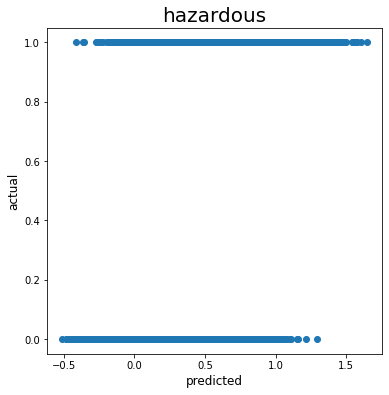

In [21]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('predicted',fontsize=12)
    ax.set_ylabel('actual',fontsize=12)
    ax.scatter(oof,y)

# Visualize Importance

In [22]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

C:\Users\Souvik\AppData\Local\Temp\ipykernel_16304\3566126545.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftw

[500]	valid_0's rmse: 0.208091
[1000]	valid_0's rmse: 0.199212
[1500]	valid_0's rmse: 0.19451
[2000]	valid_0's rmse: 0.191958
[2500]	valid_0's rmse: 0.189737
[3000]	valid_0's rmse: 0.188604
[3500]	valid_0's rmse: 0.187707
[4000]	valid_0's rmse: 0.186799
fit fold=0  25.935[s]
Fold 0 RMSLE: 0.1867



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.212186
[1000]	valid_0's rmse: 0.203067
[1500]	valid_0's rmse: 0.198317
[2000]	valid_0's rmse: 0.195867
[2500]	valid_0's rmse: 0.194005
[3000]	valid_0's rmse: 0.192648
[3500]	valid_0's rmse: 0.191834
[4000]	valid_0's rmse: 0.191206
fit fold=1  24.956[s]
Fold 1 RMSLE: 0.1910



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.213346
[1000]	valid_0's rmse: 0.205067
[1500]	valid_0's rmse: 0.200699
[2000]	valid_0's rmse: 0.197496
[2500]	valid_0's rmse: 0.195848
[3000]	valid_0's rmse: 0.194594
[3500]	valid_0's rmse: 0.193613
[4000]	valid_0's rmse: 0.192749
[4500]	valid_0's rmse: 0.192401
fit fold=2  28.832[s]
Fold 2 RMSLE: 0.1921



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.213621
[1000]	valid_0's rmse: 0.20372
[1500]	valid_0's rmse: 0.197921
[2000]	valid_0's rmse: 0.194829
[2500]	valid_0's rmse: 0.192182
[3000]	valid_0's rmse: 0.190936
[3500]	valid_0's rmse: 0.189823
[4000]	valid_0's rmse: 0.188969
fit fold=3  25.060[s]
Fold 3 RMSLE: 0.1889



C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Souvik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[500]	valid_0's rmse: 0.210971
[1000]	valid_0's rmse: 0.202455
[1500]	valid_0's rmse: 0.197414
[2000]	valid_0's rmse: 0.194025
[2500]	valid_0's rmse: 0.192288
[3000]	valid_0's rmse: 0.190982
[3500]	valid_0's rmse: 0.190223
[4000]	valid_0's rmse: 0.189702
fit fold=4  26.933[s]
Fold 4 RMSLE: 0.1896

--------------------------------------------------
FINISHED | Whole RMSLE: 0.1897


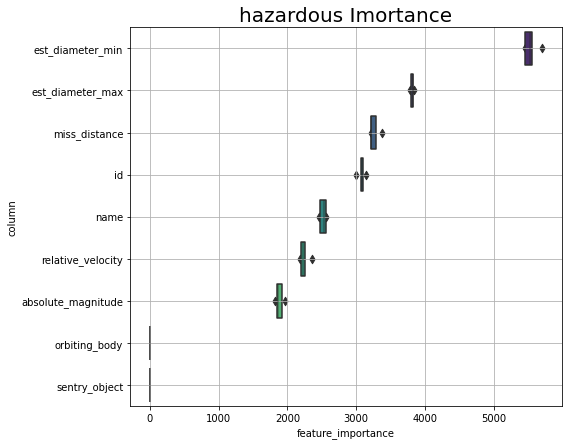

In [23]:
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)

In [24]:
preds=[]
for i in range(5):
    preds += [models[i].predict(test_feat_df.values)/5]
predsT=np.array(preds).T
preds2=[]
preds3=[]
for item in predsT:
    value=sum(item)
    preds2+=[value]
    preds3+=[int(np.where(value<0.5,0,1))]
print(preds2[0:5])
print(preds3[0:5])

[-0.0030184514013575333, -0.0015495395662046773, 0.3506143943346559, 0.00030795882422732994, 0.8457500571886233]
[0, 0, 0, 0, 1]


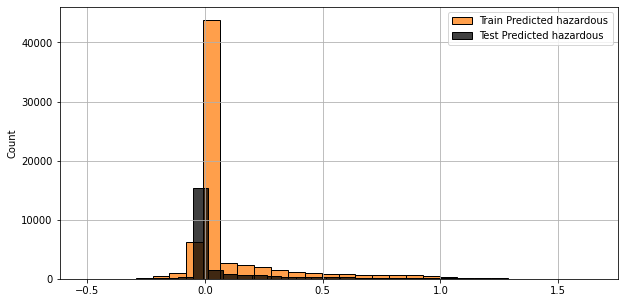

In [25]:
for i in range(1):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(oof, label='Train Predicted '+target[i], ax=ax, color='C1',bins=30)
    sns.histplot(preds2, label='Test Predicted '+target[i], ax=ax, color='black',bins=30)
    ax.legend()
    ax.grid()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(testY,preds3))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     20496
        True       0.86      0.69      0.77      2213

    accuracy                           0.96     22709
   macro avg       0.91      0.84      0.87     22709
weighted avg       0.96      0.96      0.96     22709



# Conclusion
- Model is created.
- Visualize Importance is done.
- Prediction is done.